## Introduction
PyTorch has revolutionized the approach to computer vision or NLP problems. It's a dynamic deep-learning framework, which makes it easy to learn and use.

In this guide, we will build an image classification model from start to finish, beginning with exploratory data analysis (EDA), which will help you understand the shape of an image and the distribution of classes. You'll learn to prepare data for optimum modeling results and then build a convolutional neural network (CNN) that will classify images according to whether they contain a cactus or not.




## Importing Library and Data

To begin, import the torch and torchvision frameworks and their libraries with numpy, pandas, and sklearn. Libraries and functions used in the code below include:

- transforms, for basic image transformations
- torch.nn.functional, which contains useful activation functions
- Dataset and Dataloader, PyTorch's data loading utility


In [2]:
pip install torch

     |████████████████████████████████| 108.1 MB 4.5 MB/s eta 0:00:01    |█████████████████████▊          | 73.4 MB 1.9 MB/s eta 0:00:18
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torchvision

     |████████████████████████████████| 1.0 MB 3.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader

%matplotlib inline

In [6]:
import os
os.getcwd()

labels=pd.read_csv('/Users/rudranimondal/Downloads/train.csv')

tarin_dir='/Users/rudranimondal/Downloads/train'
test_dir='/Users/rudranimondal/Downloads/test'

In [7]:
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [8]:
labels['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

## Image Pre-processing
Images in a dataset do not usually have the same pixel intensity and dimensions. In this section, you will pre-process the dataset by standardizing the pixel values.
The next required process is transforming raw images into tensors so that the algorithm can process them.

Standardize the image by defined mean and standard deviation because using raw image data will not give the desired results.


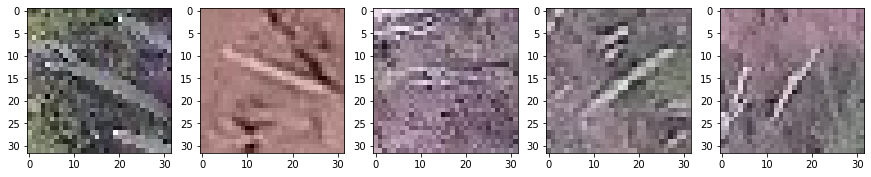

In [13]:
import matplotlib.image as img
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(labels[labels['has_cactus'] == 1]['id'][-5:]):
    path = os.path.join(tarin_dir,idx)
    ax[i].imshow(img.imread(path))

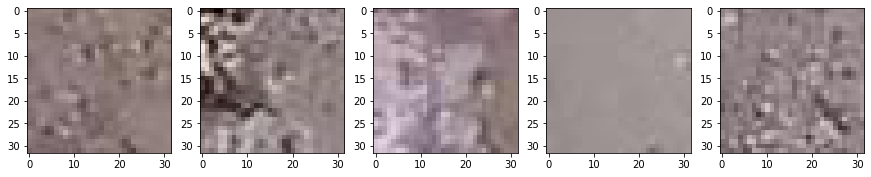

In [14]:
fig,ax=plt.subplots(1,5,figsize=(15,3))
for i,idx in enumerate(labels[labels['has_cactus']==0]['id'][-5:]):
    path=os.path.join(tarin_dir,idx)
    ax[i].imshow(img.imread(path))

In [21]:
def imshow(image,ax=None,title=None,normalize=True):
    if ax is None:
        fig,ax=plt.subplots()
    image=image.numpy().transpose((1,2,0))
    
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax    

In [22]:
class CactiDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_name,label = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

## Normalization
You can stack multiple image transformation commands in transform.Compose. Normalizing an image is an important step that makes model training stable and fast.

In [27]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean,std)])

test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean,std)])

valid_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean,std)])

## Splitting the Dataset

How well the model can learn depends on the variety and volume of the data. We need to divide our data into a training set and a validation set using train_test_split.
- Training dataset: The model learns from this dataset's examples. It fits a parameter to a classifier.

- Validation dataset: The examples in the validation dataset are used to tune the hyperparameters, such as learning rate and epochs. The aim of creating a validation set is to avoid large overfitting of the model. It is a checkpoint to know if the model is fitted well with the training dataset.

- Test dataset: This dataset test the final evolution of the model, measuring how well it has learned and predicted the desired output. It contains unseen, real-life data.


In [28]:
train,valid_data=train_test_split(labels,stratify=labels.has_cactus,test_size=0.2)

In [29]:
submission=pd.read_csv('/Users/rudranimondal/Downloads/sample_submission.csv')

In [30]:
train_data=CactiDataset(train,tarin_dir,train_transform)
valid_data=CactiDataset(valid_data,tarin_dir,valid_transform)
test_data=CactiDataset(submission,test_dir,test_transform)

In [41]:
# define the hyperparameters
num_epochs=35
num_classes=2
batch_size=25
learning_rate=0.001


In [42]:
# cpu or gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [43]:
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle=False, num_workers=0)

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


training images
torch.Size([3, 32, 32])


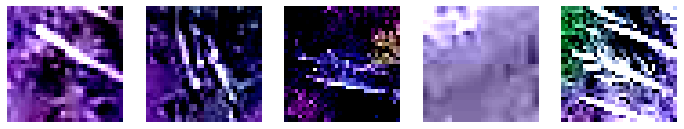

In [45]:
trainimages, trainlabels = next(iter(train_loader))

fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
print('training images')
for i in range(5):
    axe1 = axes[i] 
    imshow(trainimages[i], ax=axe1, normalize=False)

print(trainimages[0].size())

## Designing a Convolution Neural Network (CNN)
If you try to recognize objects in a given image, you notice features like color, shape, and size that help you identify objects in images. The same technique is used by a CNN. The two main layers in a CNN are the convolution and pooling layer, where the model makes a note of the features in the image, and the fully connected (FC) layer, where classification takes place.



## Convolution Layer
Mathematically, convolution is an operation performed on two functions to produce a third function. Convolution is operating in speech processing (1 dimension), image processing (2 dimensions), and video processing (3 dimensions). The convolution layer forms a thick filter on the image.

The convolutional layer’s output shape is affected by the choice of kernel size, input dimensions, padding, and strides (number of pixels by which the window moves).

In this model, a 3x3 kernel size is used. It will have 27 weights and 1 bias.


This is what happens behind the CNN.




## Pooling Layer
A drawback of a convolution feature map is that it records the exact position of features. Even the smallest development in the feature map will produce different results. This problem is solved by down sampling the feature map. It will be a lower version of the image with important features intact. In this model, max pooling is used. It calculates the maximum value of each patch of the feature map.


## Activation Layer

During forward propagation, activation function is used on each layer. The non-linearity transformation is introduced by the activation function. A neural network without an activation function is just a linear regression model, so it can not be ignored. Below is a list of activation functions.



In [46]:
epochs = 35
batch_size = 25
learning_rate = 0.001

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(720, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [48]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=720, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


## Loss
There are different types of losses implemented in machine learning. In this guide, cross-entropy loss is used. In this context, it is also known as log loss. Notice it has the same formula as that of likelihood, but it contains a log value.


## Optimization
Select any one optimizer algorithm available in the torch.optim package. The optimizers have some elements of the gradient descent. By changing the model parameters, like weights, and adding bias, the model can be optimized. The learning rate will decide how big the steps should be to change the parameters.

Calculate what a small change in each weight would do to the loss function (selecting the direction to reach minima).
Adjust each weight based on its gradient (i.e., take a small step in the determined direction).
Keep doing steps 1 and 2 until the loss function gets as low as possible.
Here, adaptive moment estimation (Adam) should be used as an optimizer. It is a blend of RMSprop and stochastic gradient descent.

Loss function and optimization go hand-in-hand. Loss function checks whether the model is moving in the correct direction and making progress, whereas optimization improves the model to deliver accurate results.


In [49]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [50]:
%%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 0.180031 	Validation Loss: 0.090564
Epoch: 2 	Training Loss: 0.106804 	Validation Loss: 0.068921
Epoch: 3 	Training Loss: 0.093339 	Validation Loss: 0.056139
Epoch: 4 	Training Loss: 0.079520 	Validation Loss: 0.054477
Epoch: 5 	Training Loss: 0.069413 	Validation Loss: 0.057785
Epoch: 6 	Training Loss: 0.067714 	Validation Loss: 0.048239
Epoch: 7 	Training Loss: 0.059642 	Validation Loss: 0.061576
Epoch: 8 	Training Loss: 0.059816 	Validation Loss: 0.057215
Epoch: 9 	Training Loss: 0.058678 	Validation Loss: 0.050824
Epoch: 10 	Training Loss: 0.051990 	Validation Loss: 0.044348
Epoch: 11 	Training Loss: 0.044546 	Validation Loss: 0.048711
Epoch: 12 	Training Loss: 0.046367 	Validation Loss: 0.047717
Epoch: 13 	Training Loss: 0.043135 	Validation Loss: 0.055685
Epoch: 14 	Training Loss: 0.042066 	Validation Loss: 0.052567
Epoch: 15 	Training Loss: 0.045604 	Validation Loss: 0.041168
Epoch: 16 	Training Loss: 0.035593 	Validation Loss: 0.043887
Epoch: 17 	Traini

In [51]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

Test Accuracy of the model: 98.05714285714286 %
